# Homework 4

For this assignment, I build different classification models to predict poverty levels. The data comes from Costa Rica. I am tasked to predict the poverty level of each household in the sample from Costa Rica on a scale of 1-4, with 1 being the most severe and 4 being the least.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Models and metrics that will be used to determine the effectiveness of my models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

#used so that warnings do not appear in the output
import warnings 
warnings.filterwarnings('ignore')

# Data

With this first part, I am going to read in the data to get an idea of what features I have in my dataset.

In [2]:
train  = pd.read_csv("/Users/nicksteil/Desktop/all/train.csv")

In [3]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


There are five features that are objects. That may pose a problem depending on which models I use. But first I am going to want to see if there are missing values.

In [6]:
train.columns[train.isnull().any()]

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

Looking at the description of the varibles provided by Kaggle, one of the variables, SQBmeaned, is defined as the square of the other variable with missing values, meaneduc, which is the average years of education of adults in the household. Since one variable is just a transformation of another, I am going to look to drop one. In order to see which one, I am going to compare each variable's respective boxplot to see if that can give me any insight as to which one should be dropped.

Text(0.5,1,'Adult Education and Poverty Level')

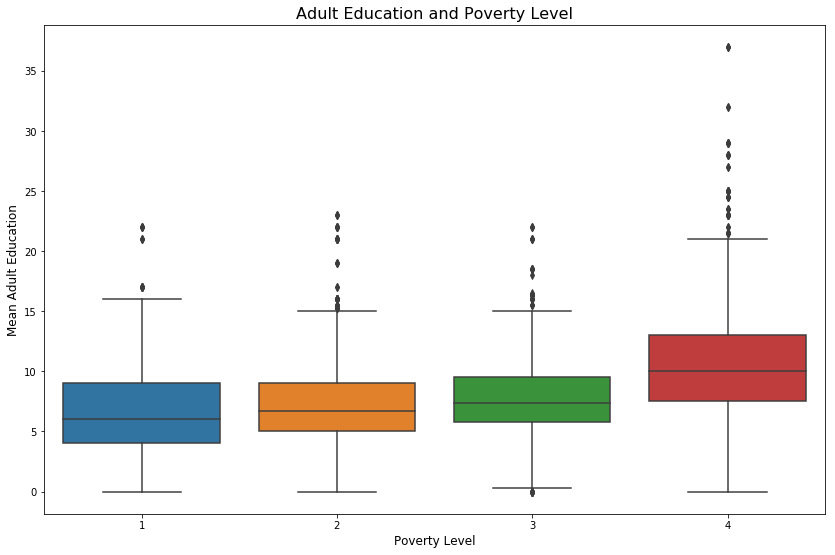

In [7]:
fig, ax = plt.subplots(figsize = (14,9))
sns.boxplot(x = "Target", y = "meaneduc", data = train)
plt.xlabel('Poverty Level', fontsize = 12)
plt.ylabel('Mean Adult Education', fontsize = 12)
plt.title('Adult Education and Poverty Level', fontsize = 16)

Text(0.5,1,'Squared Average Adult Education and Poverty Level')

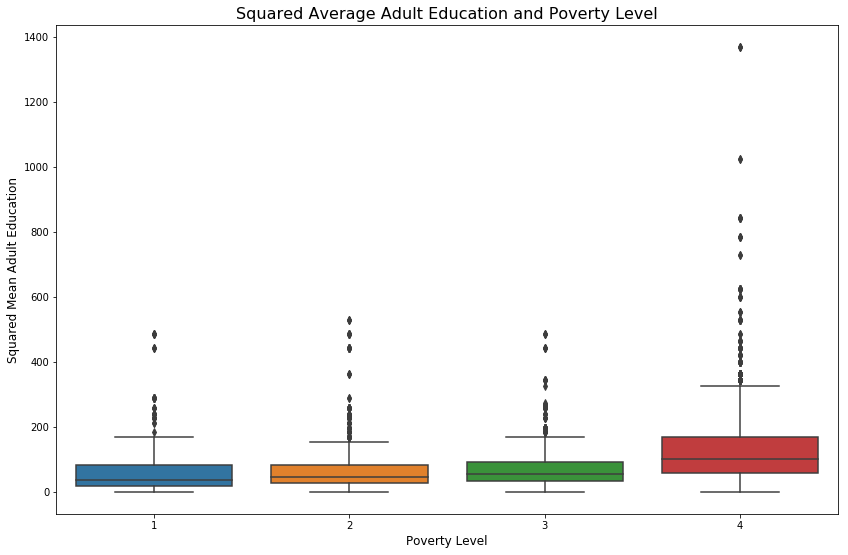

In [8]:
fig, ax = plt.subplots(figsize = (14,9))
sns.boxplot(x = "Target", y = "SQBmeaned", data = train)
plt.xlabel('Poverty Level', fontsize = 12)
plt.ylabel('Squared Mean Adult Education', fontsize = 12)
plt.title('Squared Average Adult Education and Poverty Level', fontsize = 16)

It looks like when I square the average education level, there appears to be more outliers. I am going to drop the squared mean education column.

In [9]:
train = train.drop("SQBmeaned", axis = 1)

Since v2a1, which is the monthly rent payment, and meanedu seems rather continous, I am going to impute the missing values in each column with their respective mean.

In [10]:
train['v2a1'].fillna(train['v2a1'].mean(), inplace = True)

In [11]:
train['meaneduc'].fillna(train['meaneduc'].mean(), inplace = True)

v18q1, which is a measure of whether a househould owns a tablet, and rez_esc, which is the number of years behind in school, take on discrete values. I am going to fill in the missing values of each of these features with their modes.

In [12]:
train['v18q1'].fillna(train['v18q1'].mode()[0], inplace = True)

In [13]:
train['rez_esc'].fillna(train['rez_esc'].mode()[0], inplace = True)

In [14]:
target = train['Target'] #want to copy the actual poverty levels of each household before they get dropped from data

In [15]:
train = train.drop("Target", axis = 1)

In [16]:
train.columns[train.isna().any()]

Index([], dtype='object')

I have filled in the missing values of my data. But I still need to take care off the features that are objects. 

In [17]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


Id and idhogar are just indicators for each househould in the sample. Those columns can actually be dropped since they will not be used by our models to try to classify each household. dependency, which is the calculated dependency rate of each househld, has both numeric and non-numeric inputs. edjefe and edjefa are both the years of education of the male and female heads of household respectively. There are instructions in the variable description that for both of these varibles, an input of "no" is equal to zero and "yes" is equal to 1. I am going to fill in the yes's and no's of edjefe and edjefa with their respective values and then convert the entire column so that all values are integers.

In [18]:
ed = {"yes" : 1, "no" : 0} #create a dict and then map them to their values using .replace

In [19]:
train['edjefe'] = train['edjefe'].replace(ed).astype(int)

In [20]:
train['edjefa'] = train['edjefa'].replace(ed).astype(int)

Without any instructions for depenedcy, I need to see the unique values of this feature to see how to best get rid of the "yes" and "no" inputs.

In [22]:
train['dependency'].unique()

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002'], dtype=object)

Based on a kernal on Kaggle, an individual did the same as with edjefe and edjefa: they changed the "yes" to 1 and
the "no" to 0. I am going to go ahead and do that. Changing the "no" to zero makes sense since the dependency ratio for this household, as defined in the description, is most likely zero. However, for "yes", it might be better to replace "yes" of a given househould with the mode of their respective poverty level. I also need to convert the object to float64 so that each value is then a float. 

In [23]:
train['dependency'] = train['dependency'].replace(ed).astype(np.float64)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 141 entries, Id to agesq
dtypes: float64(8), int64(131), object(2)
memory usage: 10.3+ MB


Now, only the two identification variables are the only object variables left in the data set. I am going to remove them since they will not be used in my models. I can now proceed with modeling.  

In [25]:
train = train.drop(['Id', 'idhogar'], axis = 1)

# Models

### Random Forest

The first model that I am going to try is a random forest. It is an ensemble method where many decision trees are trained to make a prediction and then vote on a classification. Each tree gets independent views of the trained data since the method relies on sampling with replacement of both the househoulds and the features. This is a very common model using in machine learning today. 

In [26]:
#split the training data and the targets into training and testing groups
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size = 0.20, random_state = 42)

The two hyperparameters of this model that I will use cross validation to tune this model are n_estimators and max_depth. n_estimators is the number of independent decision trees that will be used in this forest. More decision trees allows the model to have more predictive power. max_depth is how deep we want are trees to go. The more the depth, the more nodes where are tree can split up the data. The metric that I use to see how good my model is is the F1 score across the four classification groups. F1 is the measure of both the precision and recall of the predictions of my model by taking the harmonic mean. A higher F1 is an indicator of a better model. 

In [28]:
#I settled on these options for my parameters. They can be changed to see which produces a better F1 score.
parameters = {'n_estimators' : [22,23,24], 'max_depth' : [8,12,16]} 
random_forest = RandomForestClassifier()

In [29]:
random_forest_cv = GridSearchCV(random_forest, parameters, cv = 3, scoring = "f1_macro")

In [30]:
def RF_Stats(model):
    model.fit(X_train, Y_train)
    print("Best Parameters: {}". format(model.best_params_))
    prediction = model.predict(X_test)
    print("F1 Score: {}".format(f1_score(Y_test, prediction, average = "macro")))
    print("Classification Report:")
    print(classification_report(Y_test, prediction, digits = 4))
    important_features = sorted(list(zip(list(X_train), model.best_estimator_.feature_importances_)), 
                            key = lambda x: x[1], reverse = True)
    pd.Series([x[1] for x in important_features], index=[x[0] for x in important_features]).plot(
                            kind='bar', figsize = (16,12), title = 'Feature Importance')
    feature, coefficient = zip(*important_features) #I unzip the tuple
    coef_table = pd.DataFrame({'Features': feature, 'Importance' : coefficient})
    print(coef_table.query("Importance <= 0.0001"))

Best Parameters: {'max_depth': 16, 'n_estimators': 23}
F1 Score: 0.8289801292328904
Classification Report:
             precision    recall  f1-score   support

          1     0.9426    0.7012    0.8042       164
          2     0.8857    0.7974    0.8393       311
          3     0.9512    0.6142    0.7464       254
          4     0.8700    0.9899    0.9261      1183

avg / total     0.8896    0.8839    0.8776      1912

       Features  Importance
131  paredother    0.000084
132   pisoother    0.000059
133  instlevel9    0.000034
134   pisonatur    0.000030
135     planpri    0.000023
136   techootro    0.000000
137   elimbasu5    0.000000
138   elimbasu6    0.000000


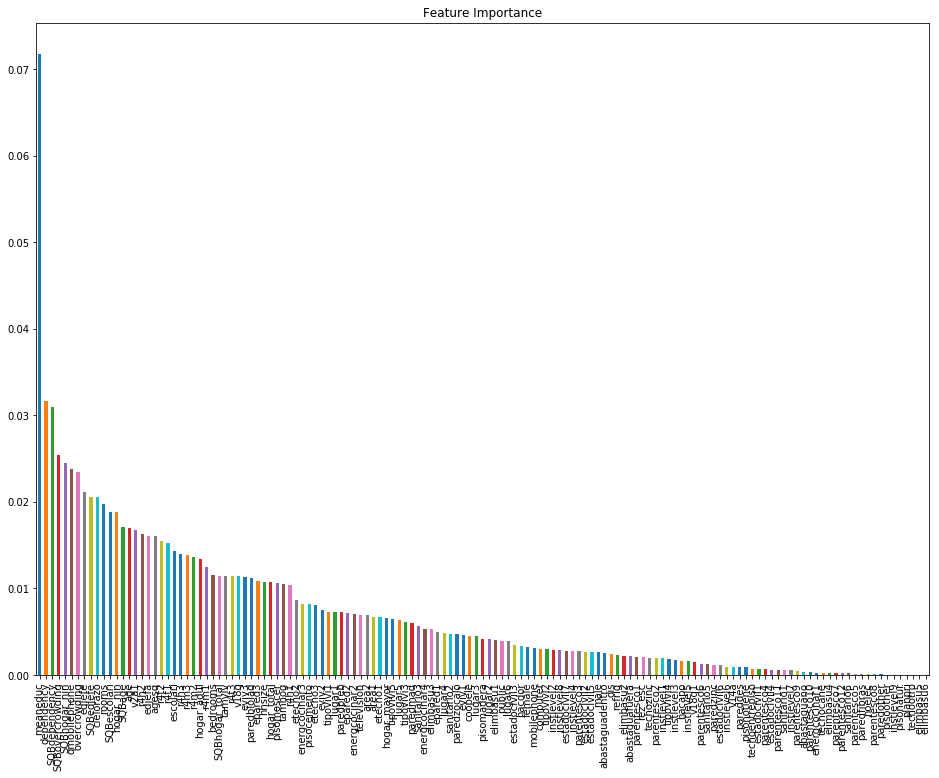

In [31]:
RF_Stats(random_forest_cv)

Based on my model, I was able to generate a pretty high F1 score with the best parameters give. Across all classes, my model was able to do a good job at predicting the classes. Precision and recall were both high for all four classes. My major concern for this model is the problem of overfitting. As the max_depth gets higher, the model is going to overfit to the data and it will not perform as well out of sample. One of the ways I am going to control for overfitting is by seeing if I can remove any features from my data. This bar plot is the relevant feature importance of each feature from our data that given by the model. The variables on the left are much more important to predict poverty levels as opposed to the ones on the right. Since it is hard to see from the plot, I print the features with the smallest relative feature importance.

### Logistic Regression

Another way that I am going to see if overfitting is a problem is by doing a logistic regression with an L2 regularization. With this regularization, this puts an added penalty on smaller coefficients of our features, thus driving them closer to zero. 

In [32]:
log_clf = LogisticRegressionCV(Cs = [0.2, 0.5, 0.7], cv = 5, penalty = 'l2', solver = 'lbfgs', 
                               multi_class = 'ovr')

In [33]:
def Log_Stats(model):
    model.fit(X_train, Y_train)
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    print("F1 Score: {}".format(f1_score(Y_test, test_prediction, average = "macro")))
    print("Classification Report:")
    print(classification_report(Y_test, test_prediction, digits = 4))
    important_features = sorted(list(zip(list(X_train), model.coef_[0])), key = lambda x: x[1], reverse = True)
    pd.Series([x[1] for x in important_features], index=[x[0] for x in important_features]).plot(
                kind='bar', figsize = (16,12), title = 'Coefficients')
    feature, coefficient = zip(*important_features)
    coef_table = pd.DataFrame({'Features': feature, 'Coefficient' : coefficient})
    print(coef_table.query("Coefficient <= 0.0001 and Coefficient >= -0.0001"))

F1 Score: 0.2536949415895862
Classification Report:
             precision    recall  f1-score   support

          1     1.0000    0.0183    0.0359       164
          2     0.3559    0.1350    0.1958       311
          3     0.0000    0.0000    0.0000       254
          4     0.6503    0.9839    0.7830      1183

avg / total     0.5460    0.6323    0.5194      1912

          Features  Coefficient
40     parentesco9     0.000088
41       paredpreb     0.000079
42     parentesco7     0.000076
43   energcocinar1     0.000072
44     paredzocalo     0.000062
45       techocane     0.000044
46      sanitario1     0.000043
47       elimbasu2     0.000037
48          SQBage     0.000033
49           agesq     0.000033
50     parentesco8     0.000016
51          noelec     0.000014
52       elimbasu5     0.000000
53    estadocivil3    -0.000001
54            v2a1    -0.000005
55    parentesco10    -0.000006
56      instlevel8    -0.000008
57       pisoother    -0.000008
58         planpri 

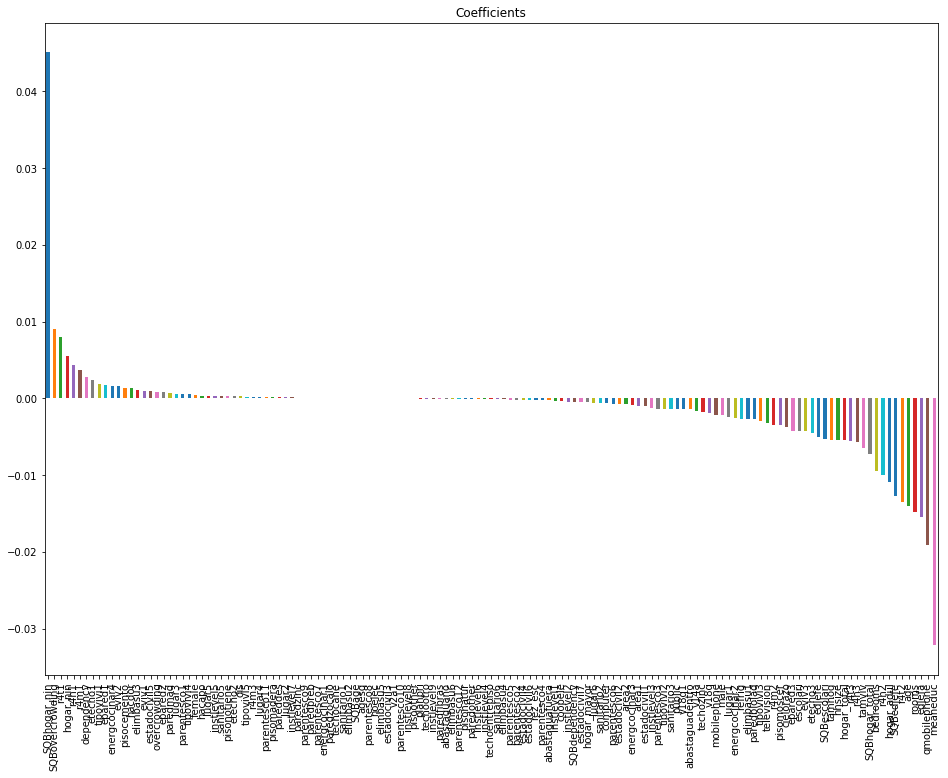

In [34]:
Log_Stats(log_clf)

This is not a good model since the F1 score is so low. However, this model does add insights into the features that have been nullified by our model. The bar plot shows the value of the coefficients of each feature. Based on the graph, there is a a range of features where the coefficients of our logisitic regression are zero. I printed those features in the table above the graph. Compared to the random forest, there are features included in both and more that are not predictors of poverty. There are other coefficients that are still very small that we could drop, but I am going to focus on just on the features that the logistic regression predicts to be zero.

### Random Forest With Less Features

I am now going use random forest again but after I drop the features that the logistic regression predicts have no
effect on poverty levels. With less features, I am interested in seeming if my F1 score improves

In [35]:
drop_columns = ['r4m3', 'energcocinar1','elimbasu2', 'techocane', 'parentesco7', 'parentesco9', 'sanitario1', 
                'SQBage', 'agesq', 'instlevel8', 'parentesco8', 'edjefe', 'paredpreb', 'paredzocalo', 'noelec', 
                'elimbasu5', 'v2a1', 'estadocivil3', 'pisoother', 'planpri', 'parentesco10', 'techootro', 
                'instlevel9', 'abastaguano', 'parentesco12', 'paredfibras', 'elimbasu6', 'pisonatur', 
                'paredother', 'instlevel4', 'techoentrepiso', 'sanitario6', 'instlevel6']    

In [36]:
train = train.drop(drop_columns, axis = 1)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.20, random_state = 42)

In [38]:
new_random = GridSearchCV(random_forest, parameters, cv = 3, scoring = "f1_macro")
new_random.fit(x_train,y_train)
print("Best Parameters: {}". format(new_random.best_params_))
prediction = new_random.predict(x_test)
print("F1 Score: {}".format(f1_score(y_test, prediction, average = "macro")))
print("Classification Report:")
print(classification_report(y_test, prediction, digits = 4))

Best Parameters: {'max_depth': 16, 'n_estimators': 22}
F1 Score: 0.8582771398093242
Classification Report:
             precision    recall  f1-score   support

          1     0.9545    0.7683    0.8514       164
          2     0.9018    0.7974    0.8464       311
          3     0.9459    0.6890    0.7973       254
          4     0.8894    0.9924    0.9381      1183

avg / total     0.9045    0.9012    0.8970      1912



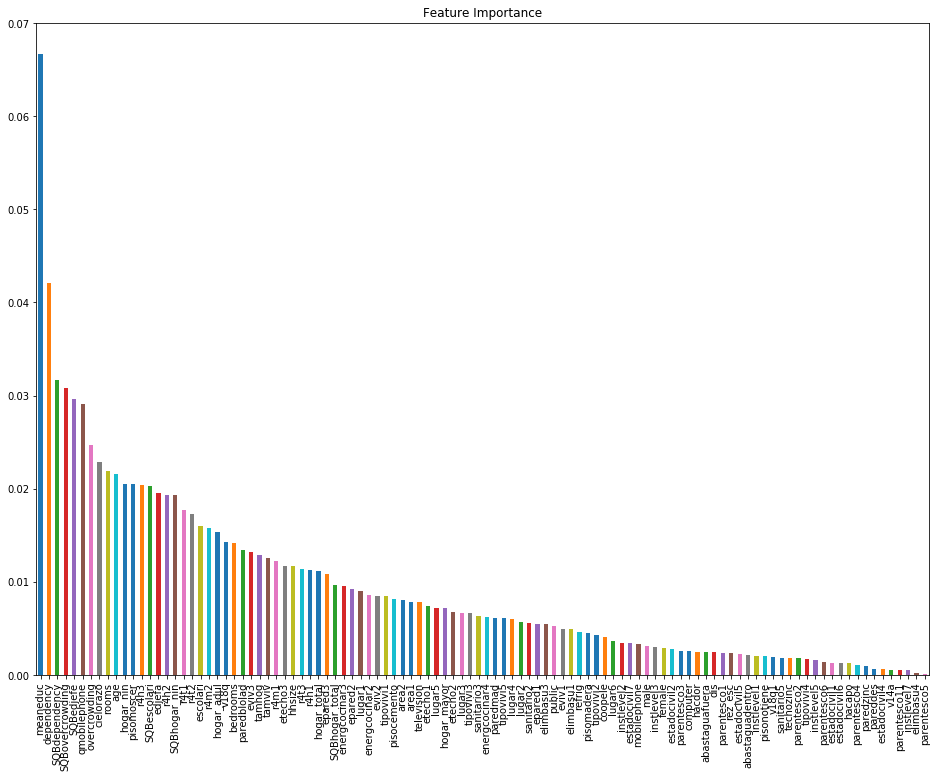

In [39]:
im_features = sorted(list(zip(list(x_train), new_random.best_estimator_.feature_importances_)), 
                            key = lambda x: x[1], reverse = True)
pd.Series([x[1] for x in im_features], index=[x[0] for x in im_features]).plot(
        kind='bar', figsize = (16,12), title = 'Feature Importance')

After dropping those features, the F1 score did improve. The precision and recall across the four classifiers also improved. This is definetly an improvement over the first time that I used random forest. There could be less of a problem with overfitting because I was able to remove many features. It would be interesting to see if I could still remove some of features with small feature performance, as indicated by the variables on the right without sacrifing my F1 score. However, the problem of overfitting because the more deep trees ensemble performs better still remains an issue.

### SVM

For my last model I will use a support vector machine classifier. I am going to use the kernal trick to creat a non-linear boundary. I use the radial form of the kernal trick with degree 2. I am going to train my model on both training sets, the original and the the one with many dropped variables comming from the logistic regression.

In [40]:
def SVM_Model(x_train, y_train, x_test, y_test):
    svm_model = SVC(C = 0.2, kernel = 'rbf', degree = 2, gamma = 4)
    svm_model.fit(x_train, y_train)
    prediction = svm_model.predict(x_test)
    print("F1 Score: {}".format(f1_score(y_test, prediction, average = "macro")))
    print("Classification Report:")
    print(classification_report(y_test, prediction, digits = 4))

In [41]:
SVM_Model(X_train, Y_train, X_test, Y_test)

F1 Score: 0.19111470113085618
Classification Report:
             precision    recall  f1-score   support

          1     0.0000    0.0000    0.0000       164
          2     0.0000    0.0000    0.0000       311
          3     0.0000    0.0000    0.0000       254
          4     0.6187    1.0000    0.7645      1183

avg / total     0.3828    0.6187    0.4730      1912



In [42]:
SVM_Model(x_train, y_train, x_test, y_test)

F1 Score: 0.19111470113085618
Classification Report:
             precision    recall  f1-score   support

          1     0.0000    0.0000    0.0000       164
          2     0.0000    0.0000    0.0000       311
          3     0.0000    0.0000    0.0000       254
          4     0.6187    1.0000    0.7645      1183

avg / total     0.3828    0.6187    0.4730      1912



These models did not perform very well compared to the random forest and the logistic regression. There F1 scores are very low and there precision and recall for certain classes is not good. One way that this model can be improved is by using cross-validation to tune these models with different hyperparameters. I could try different kernals to see which improves the F1 score of these models. I tried to do that but my computer could not handle it. The fact the F1 score remained the same for the model with the dropped features suggests, that overall I can eliminate these features. These features are not important to predict poverty levels.   